In [ ]:
# Exploratory Data Analysis: Predict DTDC Proyect

# This notebook presents an exploratory data analysis of the "DTDC Courier Dataset", which contains detailed shipment records including origin/destination, weights, delivery dates, and pricing data.
# Data source: Keggle - DTDC Courier Dataset: https://www.kaggle.com/datasets/ravindrasinghrana/dtdc-courier-dataset

# Project objective:
# The main goals of this project are:
# -Clean and preprocess raw logistics data
# -Analyze delivery times, costs, and shipping modes across Indian cities
# -Identify strategic cities through network centrality analysis
# -Route optimization based on delivery time and cost using Dijkstra’s algorithm
# -Identify strategic logistics hubs using network centrality analysis (degree, betweenness, closeness)

In [2]:
# Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Load dataset
db = pd.read_csv("Dataset_Generator_for_DTDC.csv")

db.head()

,Origin,Destination,Pouch No,Date,Sender's Name,Sender Phone,Sender Address,Sender City,Sender State,Sender Pincode,...,Company Stamp,Receiver Signature,Receive Date,Tariff,VAS Charges,Total Amount,Mode,Risk Surcharge,Mode of Payment,Nature of Consignment
0,Nagpur,Jamshedpur,55e275ad-8da9-49c9-986c-93134fef2c19,2025-06-25,Megha Majumdar,6137840452,"H.No. 425 Varughese Chowk, Above Shop, Nagpur,...",Nagpur,Maharashtra,264582,...,NaN,NaN,2025-06-30,147.22,70.09,217.31,Express,Carrier,Cash,Dox
1,Jaipur,Vizag,7fab4175-11b2-4090-a0ed-4571ccd68878,2025-06-27,Nanda-Saraf,52907142,"48/880, Tripathi, Above Shop, Jaipur, Rajastha...",Jaipur,Rajasthan,200155,...,NaN,NaN,2025-06-28,256.83,82.20,339.03,Surface,Carrier,Card,Dox
2,Lucknow,Bhubaneswar,5231428d-b524-433e-8043-45c7e39a94aa,2025-06-27,Contractor LLC,5081512738,"257, Kulkarni Path, Above Shop, Lucknow, Uttar...",Lucknow,Uttar Pradesh,353311,...,NaN,NaN,2025-06-28,432.45,107.63,540.08,Surface,Carrier,Cash,Non-Dox
3,Coimbatore,Mumbai,2f556b38-298d-4e8c-9310-4e6a3a5fbe61,2025-06-11,Krishna Hans,1518559754,"83/17 Sridhar Zila, Above Shop, Coimbatore, Ta...",Coimbatore,Tamil Nadu,553663,...,NaN,NaN,2025-06-15,1162.00,25.23,1187.23,Express,Carrier,Card,Non-Dox
4,Meerut,Vijayawada,c3154041-34eb-435e-94d8-0900e6a9ed01,2025-07-01,Kuruvilla-Tiwari,1666398391,"16/64 Jayaraman Circle, Above Shop, Meerut, Ut...",Meerut,Uttar Pradesh,273143,...,NaN,NaN,2025-07-05,285.55,67.70,353.25,Surface,Carrier,Cash,Dox


In [4]:
# Dataset Overview
def summary_db (db):
    summary = pd.DataFrame()
    summary["Data type"] = db.dtypes
    summary["Missing"] = round(db.isnull().mean() * 100, 2)
    summary["Unique values"] = db.nunique()
    
    numeric_db = db.select_dtypes(include=[np.number])
    summary["Mean"] = numeric_db.mean()
    summary["Median"] = numeric_db.median()
    summary["Std dev"] = numeric_db.std()
    summary["Min"] = numeric_db.min()
    summary["Max"] = numeric_db.max()
    
    return summary

summary_db(db)

# Observations
# The dataset contains 49,639 records and 42 columns, with detailed information about shipments including origin, destination, weights, costs, and delivery dates.
# High-cardinality columns like Pouch No, Consignment No, and Sender Address, have almost all unique values and will not be useful for aggregation or grouping.
# Sender GSTIN has 46.1% missing, Recipient GSTIN 72.1%, Sender Signature 39.9%, and Company Stamp 59.9%; have high null rates.
# Date columns (Date, Sender Date, Receive Date, Expiry Date) are in string format and need to be converted to datetime.
# Some object-type columns like Mode, Paperwork, and Risk Surcharge are categorical and will be converted to category type for optimization.

,Data type,Missing,Unique values,Mean,Median,Std dev,Min,Max
Origin,object,0.00,36,NaN,NaN,NaN,NaN,NaN
Destination,object,0.00,36,NaN,NaN,NaN,NaN,NaN
Pouch No,object,0.00,49639,NaN,NaN,NaN,NaN,NaN
Date,object,0.00,30,NaN,NaN,NaN,NaN,NaN
Sender's Name,object,0.00,41841,NaN,NaN,NaN,NaN,NaN
Sender Phone,int64,0.00,49639,5.010054e+09,5.018929e+09,2.892645e+09,17108.00,9.999872e+09
Sender Address,object,0.00,49639,NaN,NaN,NaN,NaN,NaN
Sender City,object,0.00,36,NaN,NaN,NaN,NaN,NaN
Sender State,object,0.00,22,NaN,NaN,NaN,NaN,NaN
Sender Pincode,int64,0.00,48435,4.997865e+05,4.994790e+05,2.886076e+05,1.00,9.999810e+05


In [5]:
# Data Cleaning and Preprocessing
date_cols = ["Date", "Sender Date", "Receive Date", "Expiry Date"]
for col in date_cols:
    db[col] = pd.to_datetime(db[col], errors="coerce")
    
db.drop(columns=["Recipient GSTIN", "Company Stamp", "Receiver Signature"], inplace=True)

db.dropna(subset=["Date", "Receive Date"], inplace=True)

db["delivery_time"] = (db["Receive Date"] - db["Date"]).dt.days

db["profit_margin"] = db["Total Amount"] - db["Tariff"] - db["VAS Charges"]

category_cols = ["Mode", "Paperwork", "Risk Surcharge", "Nature of Consignment"]
for col in category_cols:
    db[col] = db[col].astype("category")

db.reset_index(drop=True, inplace=True)

summary_db(db)

# Observations
# All date columns were successfully converted to datetime format.
# New variables were created:
# - delivery_time: calculated as difference in days, between Receive Date and Date.
# - profit_margin: computed as Total Amount - Tariff - VAS Charges.
# Object columns with low cardinality were converted to category.
# High-cardinality fields were retained for traceability but not used in aggregations.
# Columns with excessive missing values were dropped.
# No null values remain in key operational fields.
# Numerical variables such as weights and pricing have reasonable ranges and no anomalies detected.

,Data type,Missing,Unique values,Mean,Median,Std dev,Min,Max
Origin,object,0.00,36,NaN,NaN,NaN,NaN,NaN
Destination,object,0.00,36,NaN,NaN,NaN,NaN,NaN
Pouch No,object,0.00,49639,NaN,NaN,NaN,NaN,NaN
Date,datetime64[ns],0.00,30,NaN,NaN,NaN,NaN,NaN
Sender's Name,object,0.00,41841,NaN,NaN,NaN,NaN,NaN
Sender Phone,int64,0.00,49639,5.010054e+09,5.018929e+09,2.892645e+09,1.710800e+04,9.999872e+09
Sender Address,object,0.00,49639,NaN,NaN,NaN,NaN,NaN
Sender City,object,0.00,36,NaN,NaN,NaN,NaN,NaN
Sender State,object,0.00,22,NaN,NaN,NaN,NaN,NaN
Sender Pincode,int64,0.00,48435,4.997865e+05,4.994790e+05,2.886076e+05,1.000000e+00,9.999810e+05


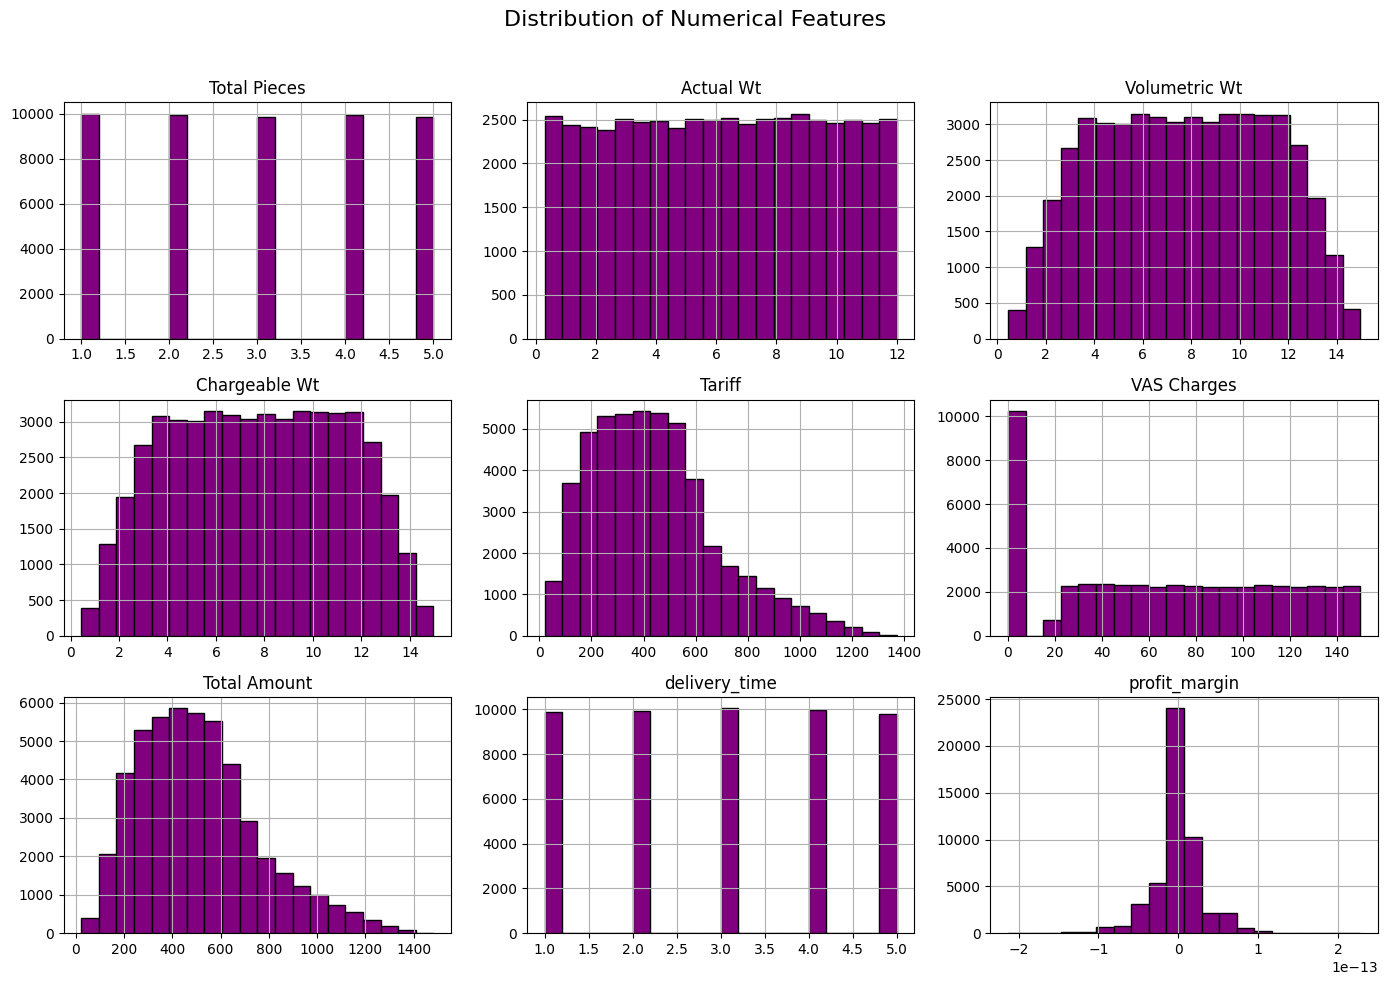

In [6]:
# Exploratory Data Analysis 

# Distribution of Numerical Variables
num_cols = ["Total Pieces", "Actual Wt", "Volumetric Wt", "Chargeable Wt","Tariff", "VAS Charges", "Total Amount", "delivery_time", "profit_margin"]

db[num_cols].hist(figsize=(14, 10), bins=20, color="purple", edgecolor="black")
plt.suptitle("Distribution of Numerical Features", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Interpretation
# Total Pieces: Uniformly distributed between 1 and 5; no dominant shipment size.
# Weights: Mostly bell-shaped; values range from ~0.5 to 15 kg.
# Tariff: Right-skewed distribution; most shipments cost between 200 and 800.
# VAS Charges: Many entries are 0; some use services priced up to 150.
# Total Amount: Similar to Tariff, with a wider spread and longer tail.
# Delivery Time: Evenly distributed from 1 to 5 days; consistent delivery scheduling.
# Profit Margin: Centered around 0; very low variance, indicating break-even pricing.

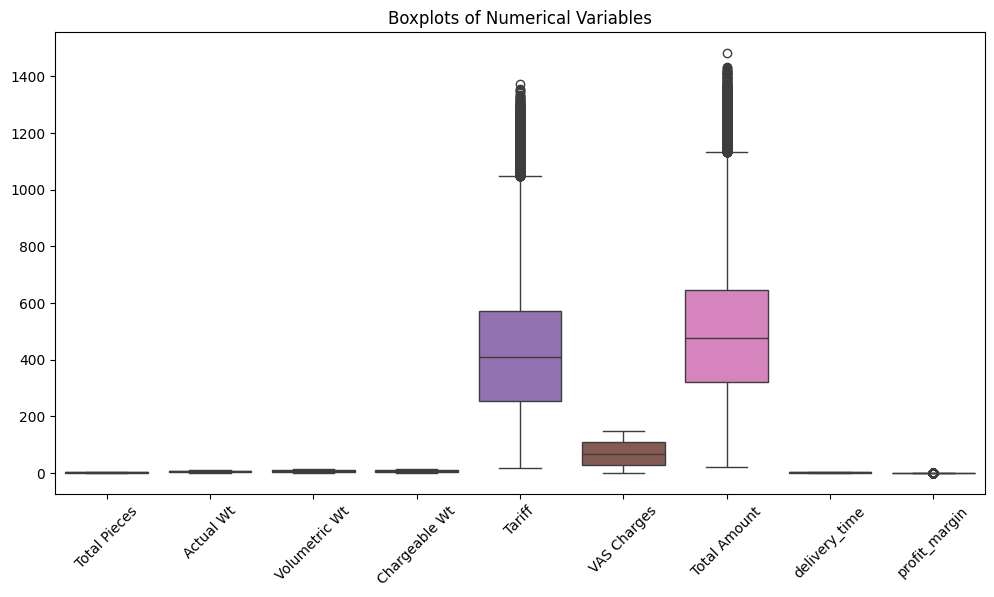

In [7]:
# Boxplots for outliers detection
plt.figure(figsize = (12,6))
sns.boxplot(data = db[num_cols])
plt.title("Boxplots of Numerical Variables")
plt.xticks(rotation = 45)
plt.show()

# Interpretation
# Tariff and Total Amount: Show high variability with multiple outliers, suggesting the presence of high-value or premium shipments.
# VAS Charges: Contains several extreme values, but most are below 100.
# Weight Variables: Fairly compact distributions with limited outliers.
# Total Pieces and Delivery Time: Discrete variables with balanced spread and no visible outliers.
# Profit Margin: Centered around zero with minimal deviation, indicating neutral or break-even pricing strategies.

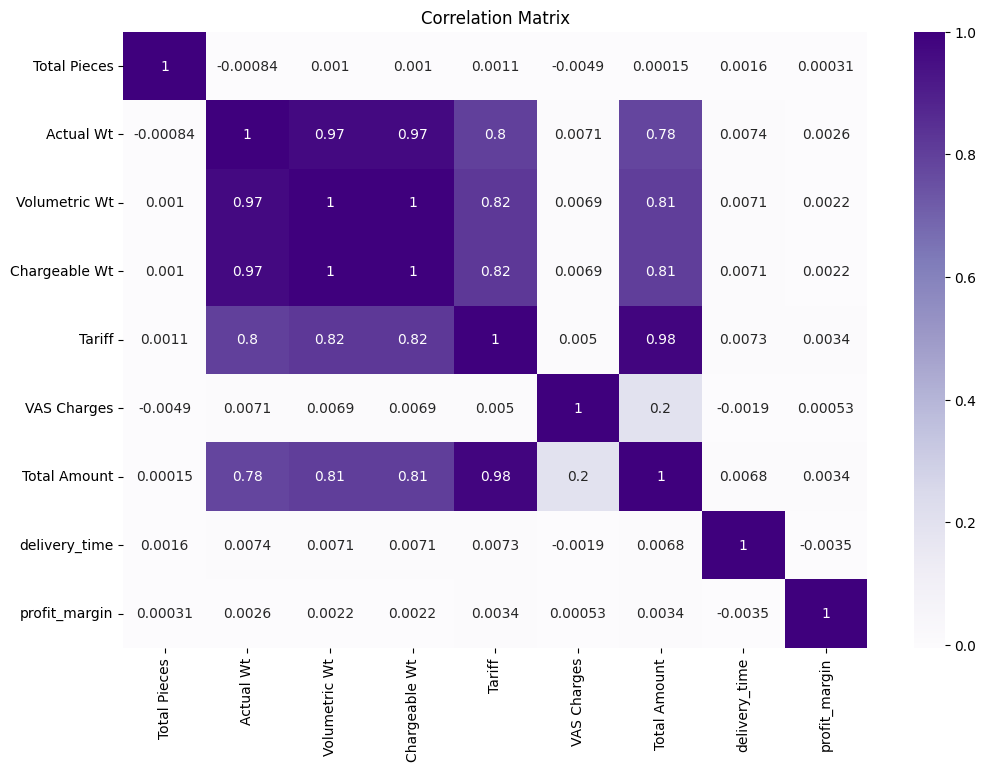

In [8]:
# Correlation Matrix
plt.figure(figsize = (12,8))
sns.heatmap(db[num_cols].corr(), annot = True, cmap = "Purples")
plt.title("Correlation Matrix")
plt.show()

# Interpretation
# Actual Wt, Volumetric Wt, and Chargeable Wt have a very strong correlations ≈0.97, as expected since they measure different weight aspects of the same shipment.
# Tariff and Total Amount have an extremely high correlation of 0.98, indicating that tariff is the main cost driver in total amount charged.
# Weight Variables and Tariff have a strong positive relationships of 0.82, suggesting pricing is weight-based.
# Profit Margin has near-zero correlation with all variables, indicating it’s not influenced directly by weight, cost, or pricing.
# Delivery Time doesn't has a significantly correlated with any variable, suggesting delays or durations are independent of costs or weights.

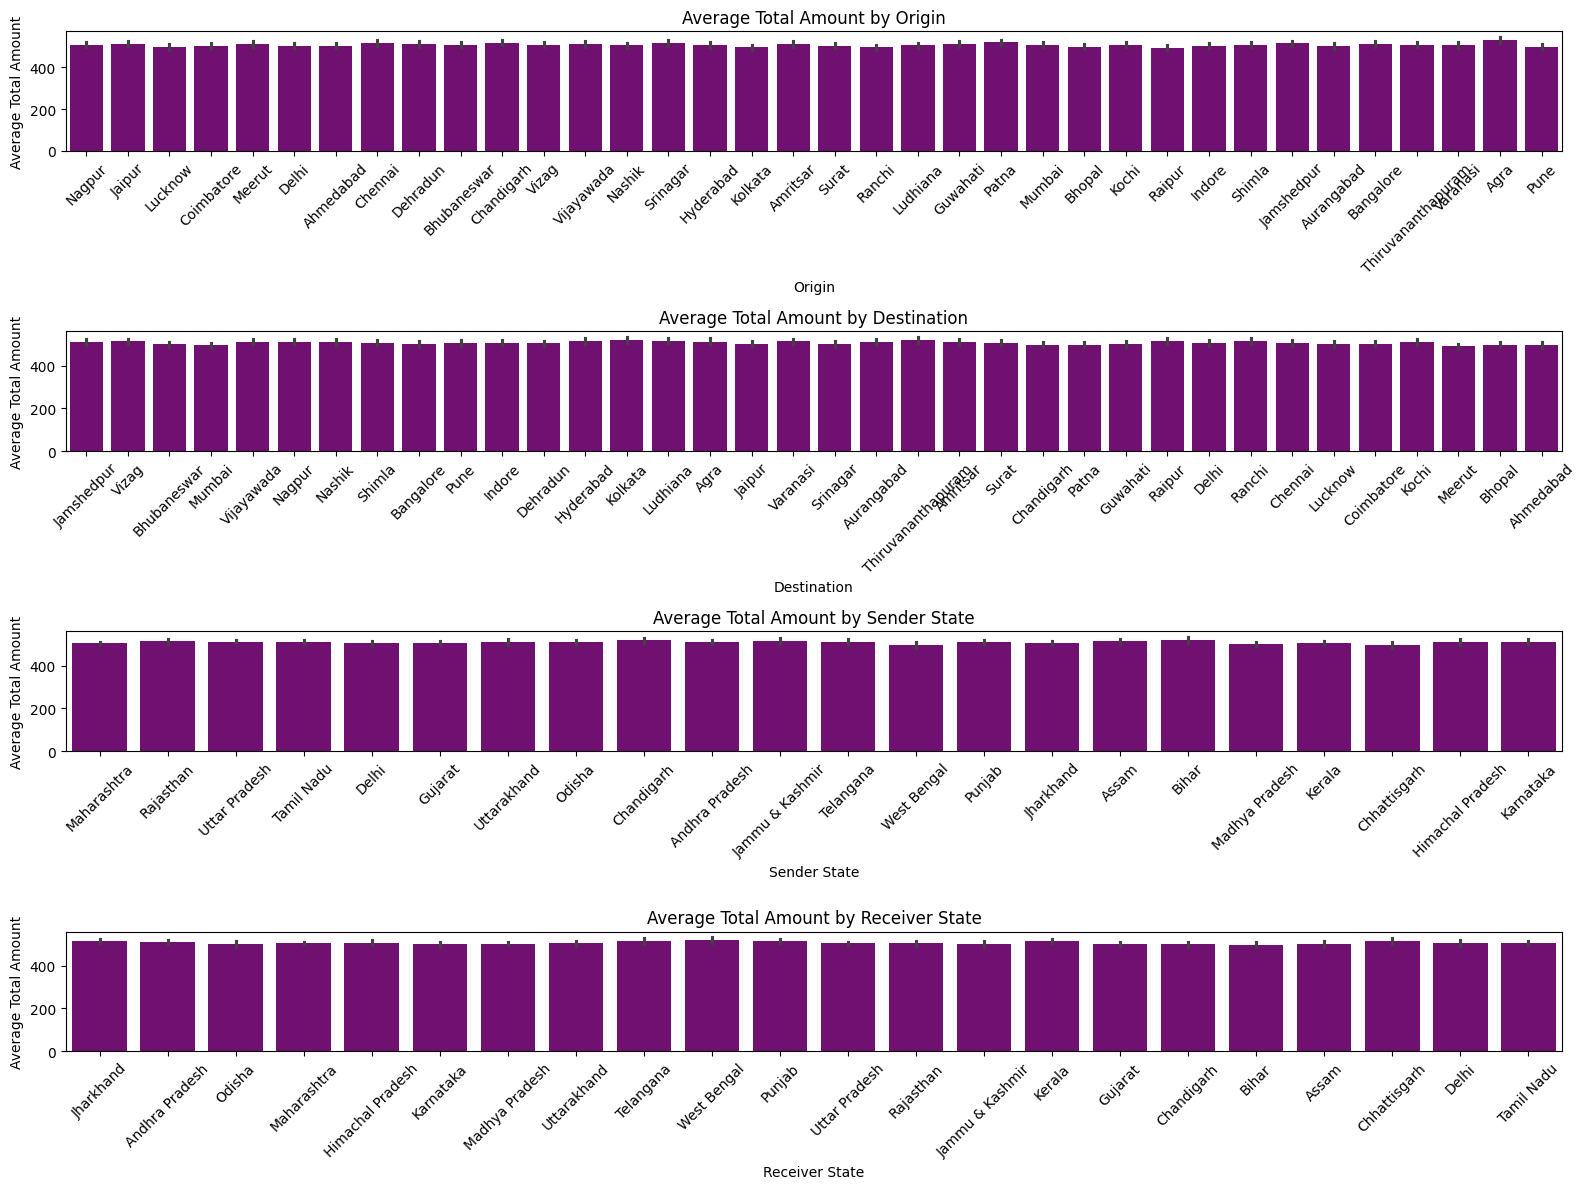

In [9]:
# Average revenue by category
cat_cols = ["Origin", "Destination", "Sender State", "Receiver State"]
target_col = "Total Amount"

fig, axes = plt.subplots(4, 1, figsize=(16, 12))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    sns.barplot(data=db, x=col, y=target_col, estimator=np.mean, ax=axes[i], color="purple")
    axes[i].set_title(f"Average {target_col} by {col}")
    axes[i].set_ylabel(f"Average {target_col}")
    axes[i].set_xlabel(col)
    axes[i].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

# Interpretation
# Origin: Cities like Agra, Jaipur, and Meerut have slightly higher average total amounts, while Pune and Lucknow show slightly lower averages.
# Destination: Mumbai and Vizag have the highest average total amounts, while Meerut and Bhubaneswar are on the lower end.
# Sender State: Maharashtra and Chandigarh show the highest average totals, while Chhattisgarh and West Bengal are lower.
# Receiver State: Kerala, Jharkhand and West Bengal have higher average total amounts, whereas Chandigarh and Uttarrakhand tend to be lower.

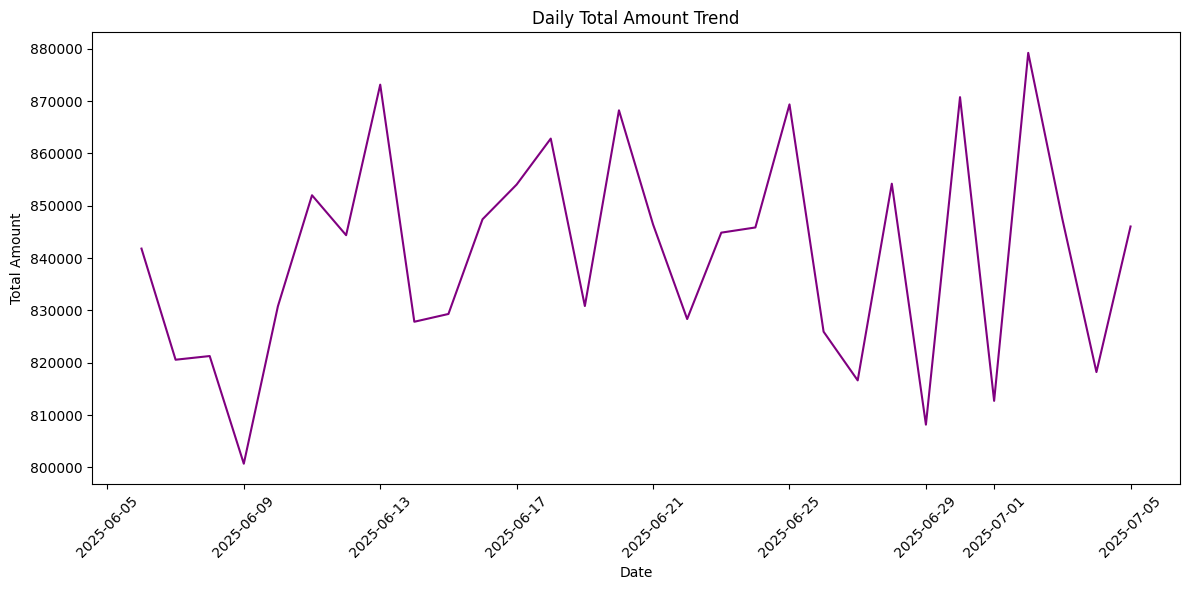

In [10]:
# Total Amount over de time
db["Day"] = db["Date"].dt.date
daily_total = db.groupby("Day")["Total Amount"].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=daily_total, x="Day", y="Total Amount", color='purple')
plt.title("Daily Total Amount Trend")
plt.ylabel("Total Amount")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Interpretation
# There are recurring peaks approximately every 4–5 days, which may correspond to batch shipping cycles or periodic customer demand.
# Minor drops like June 9th, June 25th and June 19th, suggest operational slowdowns or lower-order volumes on specific days.
# The highest revenue spike occurred on July 1st.

In [11]:
# Route Optimization using Graph Theory
# This script uses Dijkstra's algorithm to find the shortest delivery route in days, between two selected cities using a logistics network modeled as a directed graph.
!pip install networkx
import networkx as nx


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [12]:
# Extract and enumerate unique cities for selection
cities = sorted(set(db["Origin"].unique()) | set(db["Destination"].unique()))
city_dict = {i: city for i, city in enumerate(cities)}

for i in range(0, len(city_dict), 3):
    row = ""
    for j in range(3):
        idx = i + j
        if idx < len(city_dict):
            row += f"{idx:2}: {city_dict[idx]:20}  "
    print(row)

 0: Agra                   1: Ahmedabad              2: Amritsar              
 3: Aurangabad             4: Bangalore              5: Bhopal                
 6: Bhubaneswar            7: Chandigarh             8: Chennai               
 9: Coimbatore            10: Dehradun              11: Delhi                 
12: Guwahati              13: Hyderabad             14: Indore                
15: Jaipur                16: Jamshedpur            17: Kochi                 
18: Kolkata               19: Lucknow               20: Ludhiana              
21: Meerut                22: Mumbai                23: Nagpur                
24: Nashik                25: Patna                 26: Pune                  
27: Raipur                28: Ranchi                29: Shimla                
30: Srinagar              31: Surat                 32: Thiruvananthapuram    
33: Varanasi              34: Vijayawada            35: Vizag                 


In [13]:
# Route Optimization Based on Delivery Time

# Manually select source and destination cities using their numeric IDs
source_id = 11   # example: 11 = Delhi
target_id = 13  # example: 13 = Hyderabad

source = city_dict[source_id]
target = city_dict[target_id]

print(f"Selected cities:\nOrigin: {source}\nDestination: {target}")

routes = db[["Origin", "Destination", "delivery_time"]].drop_duplicates()

# Graph with delivery time as edge weight
G = nx.DiGraph()
for _, row in routes.iterrows():
    origin = row["Origin"]
    destination = row["Destination"]
    time = row["delivery_time"]
    G.add_edge(origin, destination, weight=time)

print(f"\nGraph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

# Find the shortest path based on delivery time
try:
    shortest_path = nx.dijkstra_path(G, source=source, target=target, weight="weight")
    shortest_time = nx.dijkstra_path_length(G, source=source, target=target, weight="weight")

    print(f"Shortest path from {source} to {target}:")
    print(" → ".join(shortest_path))
    print(f"Total delivery time: {shortest_time} days")
except nx.NetworkXNoPath:
    print(f"\nNo path found between {source} and {target}.")

# Interpretation
# Selected cities: The delivery route is being analyzed from Chandigarh origin, to Jamshedpur destination.
# The graph contains 36 unique cities or nodes and 1,260 possible delivery connections, edges, representing the logistics network.
# Using Dijkstra’s algorithm, the shortest path based on delivery time between these two cities is direct, meaning there’s a direct shipment route from Chandigarh to Jamshedpur with the total delivery time for this shipment route is 1 day.

Selected cities:
Origin: Delhi
Destination: Hyderabad

Graph has 36 nodes and 1260 edges.
Shortest path from Delhi to Hyderabad:
Delhi → Hyderabad
Total delivery time: 3 days


In [18]:
# Route Optimization Based on Delivery 

# Manually select source and destination cities using their numeric IDs
source_id = 7    # example: 7 = Chandigarh
target_id = 16   # example: 16 = Jamshedpur

source = city_dict[source_id]
target = city_dict[target_id]

print(f"Selected cities:\nOrigin: {source}\nDestination: {target}")

routes = db[["Origin", "Destination", "Total Amount"]].drop_duplicates()
routes = routes.groupby(["Origin", "Destination"], as_index=False)["Total Amount"].min()

# Graph with cost as weight
G = nx.DiGraph()
for _, row in routes.iterrows():
    origin = row["Origin"]
    destination = row["Destination"]
    cost = row["Total Amount"]
    G.add_edge(origin, destination, weight=cost)

print(f"\nGraph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

# Find the cheapest route
try:
    cheapest_path = nx.dijkstra_path(G, source=source, target=target, weight="weight")
    cheapest_cost = nx.dijkstra_path_length(G, source=source, target=target, weight="weight")

    print(f"Cheapest path from {source} to {target}:")
    print(" → ".join(cheapest_path))
    print(f"Total delivery cost: ₹ {cheapest_cost:.2f}")

except nx.NetworkXNoPath:
    print(f"No delivery path found from {source} to {target}.")

# Interpretation
# The origin is Chandigarh and the destination is Jamshedpur.
# The graph contains 36 unique cities or nodes and 1,260 possible delivery connections, edges, representing the logistics network.
# The delivery from Chandigarh to Jamshedpur costs approximately ₹109.85. This analysis allows identification of the most cost-effective delivery routes.

Selected cities:
Origin: Chandigarh
Destination: Jamshedpur

Graph has 36 nodes and 1260 edges.
Cheapest path from Chandigarh to Jamshedpur:
Chandigarh → Jamshedpur
Total delivery cost: ₹ 109.85


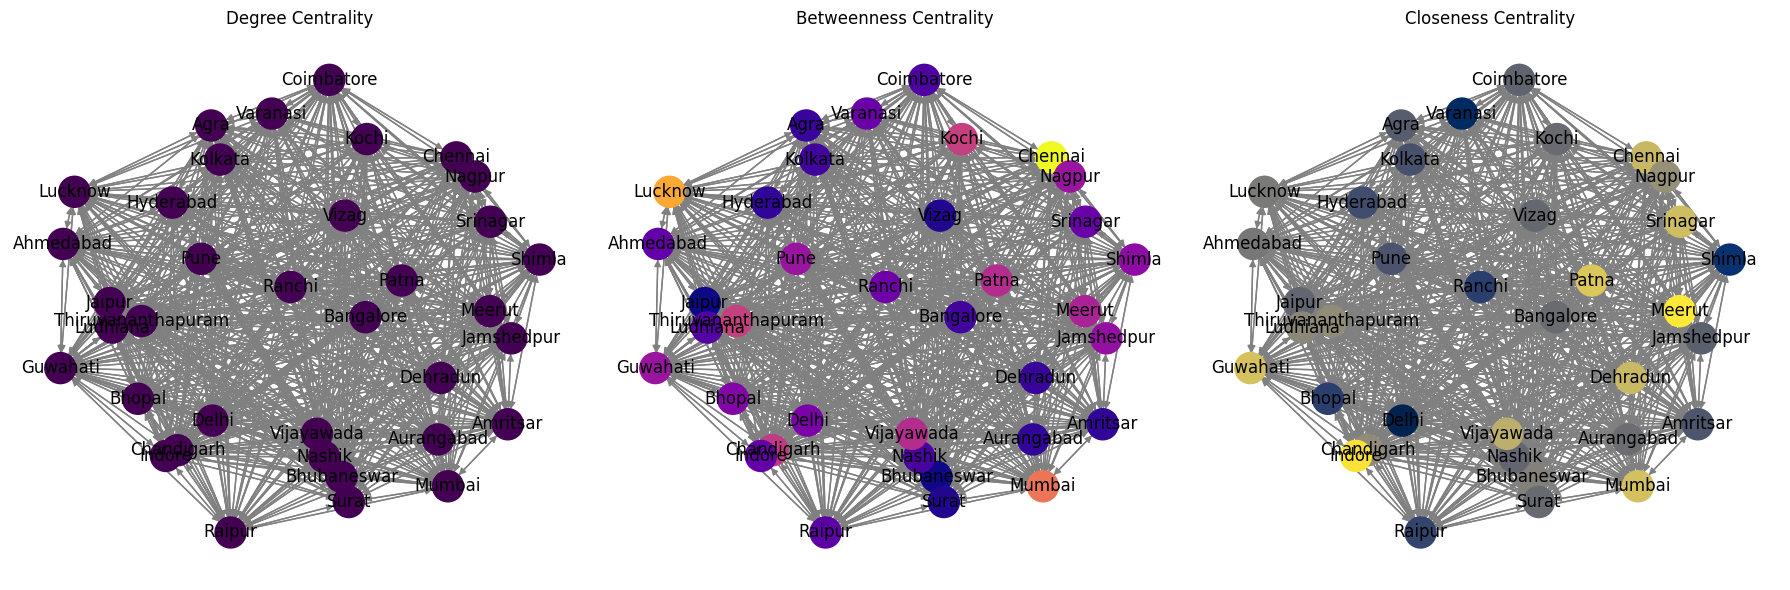

In [15]:
# Network Centrality Analysis for Logistic Optimization
# Centralities
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G, weight='weight')
closeness_centrality = nx.closeness_centrality(G, distance='weight')

pos = nx.spring_layout(G, seed=42)

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
nx.draw(G, pos, node_color=list(degree_centrality.values()), node_size=500,
        cmap=plt.cm.viridis, with_labels=True, edge_color='gray')
plt.title("Degree Centrality")

plt.subplot(1, 3, 2)
nx.draw(G, pos, node_color=list(betweenness_centrality.values()), node_size=500,
        cmap=plt.cm.plasma, with_labels=True, edge_color='gray')
plt.title("Betweenness Centrality")

plt.subplot(1, 3, 3)
nx.draw(G, pos, node_color=list(closeness_centrality.values()), node_size=500,
        cmap=plt.cm.cividis, with_labels=True, edge_color='gray')
plt.title("Closeness Centrality")

plt.tight_layout()
plt.show()

# Interpretation
# Degree Centrality: Measures how many direct connections each city has. Cities with brighter colors are more directly connected with many direct shipments.
# Betweenness Centrality: Measures how often a city acts as a "bridge" between two other cities on the shortest routes. Cities with brighter colors are critical intermediaries; if they fail, they could affect many delivery routes.
# Closeness Centrality: Measures how close a city is to the rest, considering delivery times. Brighter cities are strategically located to reach others quickly, making them ideal as distribution centers.

In [16]:
# Calculate top 5 nodes for each centrality measure
top_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
top_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
top_closeness = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]

print("Top 5 Cities by Degree Centrality:")
for city, score in top_degree:
    print(f"{city}: {score:.4f}")

print("\nTop 5 Cities by Betweenness Centrality:")
for city, score in top_betweenness:
    print(f"{city}: {score:.4f}")

print("\nTop 5 Cities by Closeness Centrality:")
for city, score in top_closeness:
    print(f"{city}: {score:.4f}")

# Interpretation
# Degree Centrality: Top cities by degree centrality are major logistics hubs with high delivery traffic, both inbound and outbound.
#  Example: Agra has a degree centrality of 2.0000, meaning it is directly connected to two other cities
# Betweenness Centrality: These cities act as critical intermediaries in the delivery network, serving as bridges that connect multiple routes.
#  Example: Chennai has a betweenness centrality of 0.0513, which means it frequently appears in the shortest paths between other city pairs.
# Closeness Centrality: Cities with high closeness centrality are strategically positioned to quickly reach or be reached by others in the network.
#  Example: Meerut has a closeness centrality of 0.0107, indicating it has relatively short delivery paths to many cities.

Top 5 Cities by Degree Centrality:
Agra: 2.0000
Ahmedabad: 2.0000
Amritsar: 2.0000
Aurangabad: 2.0000
Bangalore: 2.0000

Top 5 Cities by Betweenness Centrality:
Chennai: 0.0513
Lucknow: 0.0412
Mumbai: 0.0336
Kochi: 0.0244
Thiruvananthapuram: 0.0244

Top 5 Cities by Closeness Centrality:
Meerut: 0.0107
Indore: 0.0106
Patna: 0.0103
Guwahati: 0.0103
Mumbai: 0.0103


In [17]:
# Save database
#db.to_csv("Dataset_Generator_for_DTDC_cleaned.csv", index=False)